# Table of Contents
<ul>
  <li>Import Libraries</li>
    <li>Connection</li>
    <li>Load Data</li>
    <li>Stationery Test</li>
    <li>Triple Exponential Smoothing</li>
    <li>RMSE Evaluation</li>
    <ul>
      <li>Aggregation Level: Product</li>
      <li>Aggregation Level: SubCategory</li>
      <li>Aggregation Level: Category</li>
    </ul>
  </li>
  <li>RMSE Barplot</li>
</ul>

# Importing all the essential libraries

In [1]:
import configparser
import snowflake.connector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose                    
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima                        
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
import statsmodels.api as sm
import warnings
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from tqdm import tqdm
from tqdm._tqdm import trange
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Connection

In [2]:
#config_file = 'credentials.conf.txt'
config_file = 'credentials.conf'

In [3]:
credentials = configparser.ConfigParser()
credentials.read(config_file)
connection = snowflake.connector.connect(**credentials['SNOWFLAKE_DEV_TASTY'])          
cursor = connection.cursor()
cursor.execute("USE DATABASE {database}".format(**credentials['SNOWFLAKE_DEV_TASTY']))
cursor.execute("USE SCHEMA {schema}".format(**credentials['SNOWFLAKE_DEV_TASTY']))

# Load Data

In [4]:
sales = pd.read_sql('''
                       SELECT *
                       FROM sales_history_05282020
                    ''', connection)

In [5]:
sales.tail()

,WEEKLY_SALES_DATE,PRODUCT_ID,STORE_ID,CATEGORY,SUB_CATEGORY,STORE_GROUP,SALES_TYPE_ID,SALES_PRICE,QUANTITY,REVENUE,PREDICTED_UNITS
1607156,2020-01-25,1210,16,07,372,2,None,4.38,183.0,801.54,211.48
1607157,2020-02-01,1210,16,07,372,2,None,4.38,206.0,902.28,198.45
1607158,2020-02-08,1210,16,07,372,2,None,4.38,190.0,832.20,183.44
1607159,2020-02-15,1210,16,07,372,2,None,4.38,202.0,884.76,199.61
1607160,2020-02-22,1210,16,07,372,2,None,4.38,165.0,722.70,193.03


In [6]:
print(sales['WEEKLY_SALES_DATE'].max())
print(sales['WEEKLY_SALES_DATE'].min())
#sales.groupby('WEEKLY_SALES_DATE').count()

2020-02-22
2017-09-02


In [7]:
#creating a copy for analysis
sales_copy = sales.copy()

### Augmented Dickey-Fuller
Augmented Dickey-Fuller unit root test suggests d value in I(d). Specifically, if p-value of ADF test > 0.1, then time series is non stationary and we should take difference until the difference pass the stationary test. 

Null Hypothesis: The series has a unit root (not-stationary)

Alternate Hypothesis: The series has no unit root (stationary).

### KPSS
Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).


- Case 1: Both tests conclude that the series is not stationary -> series is not stationary
- Case 2: Both tests conclude that the series is stationary -> series is stationary
- Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
- Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

Sources: 

https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f

https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

In [8]:
def stationary_test(product_id):
    # For SALES_HISTORY for the given product IDs
    prod_details = sales_copy[(sales_copy["PRODUCT_ID"] == product_id)]
    prod_summ = prod_details.groupby("WEEKLY_SALES_DATE")["QUANTITY", "PREDICTED_UNITS"].sum()

    #creating a series of datetime indices to adjust for missing week dates
    #adding shift to move it by a day 'D' from Sunday to Saturday
    idx = pd.date_range(start = prod_details["WEEKLY_SALES_DATE"].min(), end = prod_details["WEEKLY_SALES_DATE"].max(),freq = "W").shift(-1, freq = 'D')
    
    #Change index type to Datetime
    prod_summ.index = prod_summ.index.astype("datetime64[ns]")

    # fill missing data with zero 
    prod_summ = prod_summ.reindex(idx, fill_value = 0)
    X = prod_summ['QUANTITY'].values
    dftest = adfuller(X)
    dfoutput = pd.Series(dftest[:4], index=['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    kpss_test = kpss(prod_summ['QUANTITY'])
    kpss_output = pd.Series(kpss_test[:3], index=['ADF Test Statistic', 'p-value', '#Lags Used'])

    print('\n ADF Results')
    for key, val in dftest[4].items():
        dfoutput['Criticial Value (%s)' % key] = val
    print(dfoutput)
    if dfoutput['p-value'] < .05:
        print('The signal is stationary by ADF test')
    else:
        print('The signal is not stationary by ADF test')

    print('\n KPSS Results')
    for key, val in kpss_test[3].items():
        kpss_output['Criticial Value (%s)' % key] = val
    print(kpss_output)
    if kpss_output['p-value'] < .05:
        print('The signal is not stationary by KPSS test')
    else:
        print('The signal is stationary by KPSS test')
    print('\t')

In [9]:
#trying for product 0026
stationary_test('0026')

C:\Users\shali\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

C:\Users\shali\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning:

p-value is greater than the indicated p-value




 ADF Results
ADF Test Statistic              -2.892116
p-value                          0.046272
#Lags Used                       0.000000
Number of Observations Used    126.000000
Criticial Value (1%)            -3.483346
Criticial Value (5%)            -2.884766
Criticial Value (10%)           -2.579156
dtype: float64
The signal is stationary by ADF test

 KPSS Results
ADF Test Statistic         0.132182
p-value                    0.100000
#Lags Used                13.000000
Criticial Value (10%)      0.347000
Criticial Value (5%)       0.463000
Criticial Value (2.5%)     0.574000
Criticial Value (1%)       0.739000
dtype: float64
The signal is stationary by KPSS test
	


# Triple Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. Time series methods like the Box-Jenkins ARIMA family of methods develop a model where the prediction is a weighted linear sum of recent past observations or lags. Exponential smoothing forecasting methods are similar in that a prediction is a weighted sum of past observations, but the model explicitly uses an exponentially decreasing weight for past observations. Specifically, past observations are weighted with a geometrically decreasing ratio.

Source: https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/<br>
Simple Smoothing:forecasting method for univariate data without a trend or seasonality;<br>
$F_{t+1}$ = $\alpha D_{t}$ + $(1- \alpha)F_{t}$
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant

Holt's Method:forecasting method for univariate data with a trend but no seasonality;<br>
$F_{t+1}$ = $a_{t}$ + $b_{t}$= Level component + Slope component <br>
$a_{t}=\alpha D_{t} + (1-\alpha)(a_{t-1}+b_{t-1})=\alpha D_{t} + (1-\alpha)(F_{t-1})$<br>
$b_{t}=\beta(a_{t} - a_{t-1}) + (1-\beta)(b_{t-1})=\beta(level_{t} - level_{(t-1)}) + (1-\beta)(Slope_{t-1})$
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant for level
- $\beta$ - smoothing constant for trend

Winters Method:forecasting method for univariate data with a trend and seasonality;<br>
$F_{t+1}$ = $(a_{t}+ b_{t})*C_{t}$= (Level component + Slope component)\* Seasonality component<br>
$a_{t}=\alpha (D_{t}/C_{t}) + (1-\alpha)(a_{t-1}+b_{t-1})$<br>
$b_{t}=\beta(a_{t} - a_{t-1}) + (1-\beta)(b_{t-1})=\beta(level_{t} - level_{(t-1)}) + (1-\beta)(Slope_{t-1})$<br>
$C_{t}=\gamma (D_{t}/a_{t}) + (1-\gamma)*C_{t}$<br>
- $F_{t+1}$ - forecast
- $D_{t}$ - Sales in time t
- $\alpha$ - smoothing constant for level
- $\beta$ - smoothing constant for trend
- $\gamma$ - smoothing constant for trend


#### Box-Cox transform:
It is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms. lambda parameter set to None (the default) lets the function find a statistically tuned value

#### Seasonality Models
In the additive model, the behavior is linear where changes over time are consistently made by the same amount, like a linear trend. In this situation, the linear seasonality has the same amplitude and frequency.
Different from the additive model, the multiplicative model has an increasing or decreasing amplitude and/or frequency over time

## Test and Training Set
- Training: from 2017-09-02 to 2019-11-16
- Test: from 2019-11-23 until 2019-12-28

### 3 Categories Analysis

In [15]:
#Global Variables
selected_category=['24','18','04']
TRAIN_START = "2017-09-02"
TRAIN_END = "2019-08-31"
TEST_START = "2019-09-07"
TEST_END = "2019-12-28"
selected_store = ['16']

#Creating an empty dataframe
performance_TES = pd.DataFrame(columns = ["CATEGORY", "SUB_CATEGORY", "STORE_ID", "PRODUCT_ID", "quantity", "e3", "yhat", "rmse_E3", "rmse_TES"])

In [11]:
#Creating folder paths for E3 & TES plots
import os
path=os.getcwd()
TES_path=path+'\TES_plots'
E3_path=path+'\E3_plots'

In [13]:
#Create the new directories 
os.mkdir(path+'\TES_plots')
os.mkdir(path+'\E3_plots')

In [14]:
TES_path

'C:\\Users\\shali\\Downloads\\TES_plots'

In [16]:
for category in tqdm(selected_category):
    # selected_store = sales_copy[sales_copy['CATEGORY']==category]['STORE_ID'].unique()
    for store in tqdm(selected_store):
        selected_product = sales_copy[(sales_copy['CATEGORY']==category) & (sales_copy['STORE_ID']==store)]['PRODUCT_ID'].unique()

        for product in selected_product:
            try:
                #prepare data
                specific_sales = sales_copy[(sales_copy['CATEGORY']==category) & (sales_copy['STORE_ID']==store) & (sales_copy["PRODUCT_ID"] == product)]
                sum_sales = specific_sales.groupby("WEEKLY_SALES_DATE")["QUANTITY","PREDICTED_UNITS"].sum()
                # setting indices to account for missing dates
                idx = pd.date_range(start = specific_sales["WEEKLY_SALES_DATE"].min(),
                                    end   = specific_sales["WEEKLY_SALES_DATE"].max(), freq = "W").shift(-1, freq = 'D')
                TEST_END = specific_sales["WEEKLY_SALES_DATE"].max()
                #dates as indices
                sum_sales.index = sum_sales.index.astype("datetime64[ns]")
                sum_sales = sum_sales.reindex(idx, fill_value = 0)
                #creating dataframe with E3 Model values
                E3_predicted_units = pd.DataFrame(sum_sales['PREDICTED_UNITS'])
                E3_predicted_units.index = E3_predicted_units.index.astype("datetime64[ns]")
                E3_predicted_units=E3_predicted_units.reindex(idx, fill_value = 0)
                #keeping original sales in the original dataframe
                sum_sales.drop(['PREDICTED_UNITS'], axis=1, inplace=True)
                
                #training set
                sum_sales_train = sum_sales.loc["2017-09-02":"2019-08-31"]
                sum_sales_train = sum_sales_train.reset_index().rename(columns = {"index":'ds', "QUANTITY": "y"})
                #test set
                sum_sales_test = sum_sales.loc["2019-09-07":"2019-12-28"]
                #pred_rev = E3_predicted_units

                #Splitting the dataset
                train_data=sum_sales.loc["2017-09-02":"2019-08-31"]
                test_data=E3_predicted_units.loc["2019-09-07":"2019-12-28"]
                import warnings
                warnings.filterwarnings('ignore')
                #Train the model
                fit = ExponentialSmoothing(train_data,seasonal_periods=52, seasonal='add').fit()
                pred={'y_hat':fit.forecast(len(test_data))}
                prediction=pd.DataFrame(pred).reset_index().rename(columns = {"index":'ds'})
                prediction_oos = prediction[(prediction["ds"]>=TEST_START)&(prediction["ds"]<=TEST_END)]
                
                #goodness of fit
                rmse_E3 = sqrt(mean_squared_error(sum_sales_test["QUANTITY"],test_data))
                rmse_TES = sqrt(mean_squared_error(sum_sales_test["QUANTITY"],prediction_oos["y_hat"]))
        
                sub_category = specific_sales['SUB_CATEGORY'].iloc[0]
                quantity = sum_sales_test["QUANTITY"]
                e3 = test_data
                yhat = prediction_oos["y_hat"].reset_index(drop=True)

                performance = {"CATEGORY":category, "SUB_CATEGORY":sub_category, "STORE_ID":store, "PRODUCT_ID":product, \
                               "quantity":quantity, "e3":e3['PREDICTED_UNITS'], "yhat":yhat.values, "rmse_E3":rmse_E3, "rmse_TES":rmse_TES}
                performance=pd.DataFrame(performance,index=sum_sales_test.index)
                
                #Append to the result dataframe
                performance_TES = performance_TES.append(performance )
                prediction=prediction.set_index('ds')

                #Forecast & fitted for fit
                plt.figure(figsize=(16,5))
                plt.title("Engage3 V.S TES:CATEGORY "+category+',PRODUCT ID'+product )
                plt.plot(sum_sales, color='g',marker='.',label = "Actual")
                plt.plot(E3_predicted_units, color='blue',marker='.',label='Engage3')
                plt.plot(prediction, color='r',marker='.',label='TES')
                plt.legend()
                #plt.show()
                
                #Split plots based on their performance
                if rmse_E3 < rmse_TES:
                        plt.savefig(E3_path+'\cat_'+str(category)+'_st_'+str(store)+'_pro_'+str(product)+'.png')
                else:
                        plt.savefig(TES_path+'\cat_'+str(category)+'_st_'+str(store)+'_pro_'+str(product)+'.png')
                plt.clf()
            except Exception as e:
                print(e, "CATEGORY:", category," STORE:", store, " PRODUCT:", product)
                plt.clf()
        print("CATEGORY:", category," STORE:", store, ' is done.')
        plt.clf()




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

cannot copy sequence with size 48 to array axis with dimension 58 CATEGORY: 24  STORE: 16  PRODUCT: 0951
cannot copy sequence with size 53 to array axis with dimension 58 CATEGORY: 24  STORE: 16  PRODUCT: 0968
cannot copy sequence with size 54 to array axis with dimension 58 CATEGORY: 24  STORE: 16  PRODUCT: 1037
cannot copy sequence with size 26 to array axis with dimension 58 CATEGORY: 24  STORE: 16  PRODUCT: 1103
cannot copy sequence with size 6 to array axis with dimension 58 CATEGORY: 24  STORE: 16  PRODUCT: 1108
CATEGORY: 24  STORE: 16  is done.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

cannot copy sequence with size 26 to array axis with dimension 58 CATEGORY: 18  STORE: 16  PRODUCT: 0074
cannot copy sequence with size 35 to array axis with dimension 58 CATEGORY: 18  STORE: 16  PRODUCT: 0364
cannot copy sequence with size 54 to array axis with dimension 58 CATEGORY: 18  STORE: 16  PRODUCT: 0390
cannot copy sequence with size 41 to array axis with dimension 58 CATEGORY: 18  STORE: 16  PRODUCT: 0622
CATEGORY: 18  STORE: 16  is done.



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

cannot copy sequence with size 41 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0029
cannot copy sequence with size 27 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0359
cannot copy sequence with size 42 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0415
cannot copy sequence with size 6 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0435
cannot copy sequence with size 30 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0579
cannot copy sequence with size 39 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 0808
cannot copy sequence with size 26 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 1072
cannot copy sequence with size 27 to array axis with dimension 58 CATEGORY: 04  STORE: 16  PRODUCT: 1077
CATEGORY: 04  STORE: 16  is done.



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:13<00:00, 67.56s/it]


<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

<Figure size 1152x360 with 0 Axes>

In [34]:
performance_TES.to_pickle("performance_TES.pkl")
performance_TES.to_csv("performance_TES.csv")

In [18]:
performance_TES.head()

,CATEGORY,SUB_CATEGORY,STORE_ID,PRODUCT_ID,quantity,e3,yhat,rmse_E3,rmse_TES
2019-09-07,24,346,16,0017,127.0,292.05,194.617003,128.160043,69.367877
2019-09-14,24,346,16,0017,129.0,355.17,196.065542,128.160043,69.367877
2019-09-21,24,346,16,0017,171.0,269.57,246.904326,128.160043,69.367877
2019-09-28,24,346,16,0017,129.0,411.98,196.203289,128.160043,69.367877
2019-10-05,24,346,16,0017,147.0,372.25,238.625236,128.160043,69.367877


# RMSE Evaluation
### Product Level

In [20]:
performance_product = pd.read_pickle("performance_TES.pkl")
np.mean(performance_product [["rmse_E3","rmse_TES"]])

rmse_E3     123.163295
rmse_TES     74.568602
dtype: float64

### Sub-category Level

In [21]:
#Add date column from index
performance_TES["date"] = performance_TES.index

In [25]:
performance_subcategory  = pd.DataFrame()

for sub_category in performance_TES['SUB_CATEGORY'].unique():
    data = performance_TES[performance_TES['SUB_CATEGORY'] == sub_category]
    rmse_E3 = sqrt(mean_squared_error(data.groupby('date')['quantity'].sum(), \
                                      data.groupby('date')['e3'].sum()))
    rmse_TES = sqrt(mean_squared_error(data.groupby('date')['quantity'].sum(), \
                                           data.groupby('date')['yhat'].sum()))   
    rmse = {"CATEGORY":sub_category, "rmse_E3":rmse_E3, "rmse_TES":rmse_TES}
    performance_subcategory = performance_subcategory.append(rmse, ignore_index=True)

In [26]:
performance_subcategory.head()

,CATEGORY,rmse_E3,rmse_TES
0,346,128.160043,69.367877
1,418,50.321541,48.195366
2,054,1299.579856,236.732526
3,349,254.937409,224.714031
4,345,160.126222,85.738392


In [27]:
np.mean(performance_subcategory[["rmse_E3","rmse_TES"]])

rmse_E3     203.123396
rmse_TES    112.452914
dtype: float64

### Category Level

In [28]:
performance_category  = pd.DataFrame()

for category in performance_TES['CATEGORY'].unique():
    data = performance_TES[performance_TES['CATEGORY'] == category]
    rmse_E3 = sqrt(mean_squared_error(data.groupby('date')['quantity'].sum(), \
                                      data.groupby('date')['e3'].sum()))
    rmse_TES = sqrt(mean_squared_error(data.groupby('date')['quantity'].sum(), \
                                           data.groupby('date')['yhat'].sum()))   
    rmse = {"CATEGORY":category, "rmse_E3":rmse_E3, "rmse_TES":rmse_TES}
    performance_category = performance_category.append(rmse, ignore_index=True)

In [29]:
performance_category

,CATEGORY,rmse_E3,rmse_TES
0,24,4593.294605,2421.049519
1,18,676.976644,376.356703
2,04,785.548417,453.233889


In [30]:
np.mean(performance_category[["rmse_E3","rmse_TES"]])

rmse_E3     2018.606555
rmse_TES    1083.546704
dtype: float64

### RMSE Bar Plot

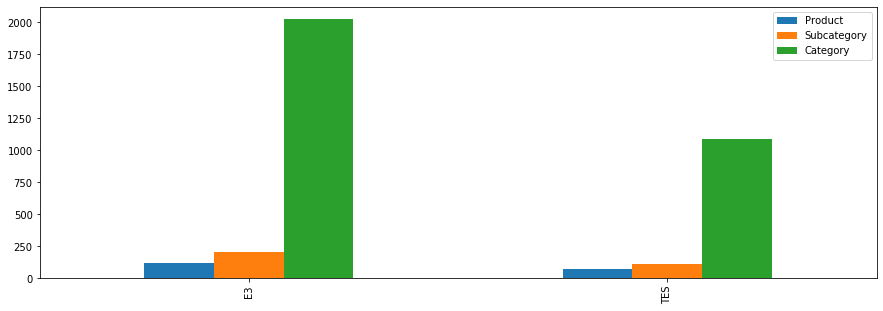

In [32]:
E3_RMSE = {"Product":np.mean(performance_product["rmse_E3"]),\
               "Subcategory":np.mean(performance_subcategory["rmse_E3"]),\
               "Category":np.mean(performance_category["rmse_E3"])}

TES_RMSE = {"Product":np.mean(performance_product["rmse_TES"]),\
               "Subcategory":np.mean(performance_subcategory["rmse_TES"]),\
               "Category":np.mean(performance_category["rmse_TES"])}

RMSE = pd.DataFrame(columns = ["Product", "Subcategory", "Category"])

RMSE = RMSE.append(E3_RMSE, ignore_index=True).append(TES_RMSE, ignore_index=True)

RMSE.index = ["E3", "TES"]

RMSE

RMSE.plot(kind = "bar", figsize = (15,5))